<a href="https://colab.research.google.com/github/jayant2014/MNIST-GAN/blob/master/GAN_Fashion_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from __future__ import print_function, division

from keras.datasets import fashion_mnist
from keras.layers import Input, Dense, Reshape, Flatten, Dropout
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU

import matplotlib.pyplot as plt
import sys
import numpy as np

##GAN Class

In [0]:
# GAN Class
class GAN():
    def __init__(self):
        self.img_rows = 28
        self.img_cols = 28
        self.channels = 1
        self.img_shape = (self.img_rows, self.img_cols, self.channels)
        self.latent_dim = 100

        optimizer = Adam(0.0002, 0.5)

        # Build and compile the discriminator
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

        # Build the generator
        self.generator = self.build_generator()

        # The generator takes noise as input and generates imgs
        z = Input(shape=(self.latent_dim,))
        img = self.generator(z)

        # For the combined model we will only train the generator
        self.discriminator.trainable = False

        # The discriminator takes generated images as input and determines validity
        validity = self.discriminator(img)

        # The combined model  (stacked generator and discriminator)
        # Trains the generator to fool the discriminator
        self.combined = Model(z, validity)
        self.combined.compile(loss='binary_crossentropy', optimizer=optimizer)


    def build_generator(self):

        model = Sequential()

        model.add(Dense(256, input_dim=self.latent_dim))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(1024))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(2048))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(np.prod(self.img_shape), activation='tanh'))
        model.add(Reshape(self.img_shape))

        model.summary()

        noise = Input(shape=(self.latent_dim,))
        img = model(noise)

        return Model(noise, img)

    def build_discriminator(self):

        model = Sequential()

        model.add(Flatten(input_shape=self.img_shape))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(256))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(1, activation='sigmoid'))
        model.summary()

        img = Input(shape=self.img_shape)
        validity = model(img)

        return Model(img, validity)

    def train(self, epochs, batch_size=128, sample_interval=50):

        # Load the dataset
        (X_train, _), (_, _) = fashion_mnist.load_data()

        # Rescale -1 to 1
        X_train = X_train / 127.5 - 1.
        X_train = np.expand_dims(X_train, axis=3)

        # Adversarial ground truths
        valid = np.ones((batch_size, 1))
        fake = np.zeros((batch_size, 1))

        for epoch in range(epochs):
            #  Train Discriminator

            # Select a random batch of images
            idx = np.random.randint(0, X_train.shape[0], batch_size)
            imgs = X_train[idx]

            noise = np.random.normal(0, 1, (batch_size, self.latent_dim))

            # Generate a batch of new images
            gen_imgs = self.generator.predict(noise)

            # Train the discriminator
            d_loss_real = self.discriminator.train_on_batch(imgs, valid)
            d_loss_fake = self.discriminator.train_on_batch(gen_imgs, fake)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

            #  Train Generator
            noise = np.random.normal(0, 1, (batch_size, self.latent_dim))

            # Train the generator (to have the discriminator label samples as valid)
            g_loss = self.combined.train_on_batch(noise, valid)

            # Plot the progress
            print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))

            # If at save interval => save generated image samples
            if epoch % sample_interval == 0:
                self.sample_images(epoch)

    def sample_images(self, epoch):
        r, c = 5, 5
        noise = np.random.normal(0, 1, (r * c, self.latent_dim))
        gen_imgs = self.generator.predict(noise)

        # Rescale images 0 - 1
        gen_imgs = 0.5 * gen_imgs + 0.5

        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i,j].imshow(gen_imgs[cnt, :,:,0], cmap='gray')
                axs[i,j].axis('off')
                cnt += 1
        fig.savefig("images/%d.png" % epoch)
        plt.show()
        plt.close()


##Run 10000 epochs

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_3 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_16 (Dense)             (None, 512)               401920    
_________________________________________________________________
leaky_re_lu_12 (LeakyReLU)   (None, 512)               0         
_________________________________________________________________
dense_17 (Dense)             (None, 256)               131328    
_________________________________________________________________
leaky_re_lu_13 (LeakyReLU)   (None, 256)               0         
_________________________________________________________________
dense_18 (Dense)             (None, 1)                 257       
Total params: 533,505
Trainable params: 533,505
Non-trainable params: 0
________________________________________________

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


0 [D loss: 0.687917, acc.: 34.38%] [G loss: 0.907282]


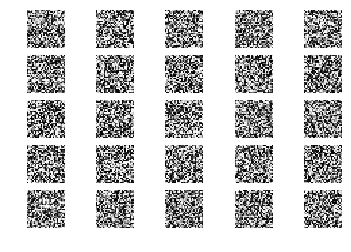

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


1 [D loss: 0.461691, acc.: 75.00%] [G loss: 0.890993]
2 [D loss: 0.292939, acc.: 90.62%] [G loss: 1.094808]
3 [D loss: 0.264966, acc.: 95.31%] [G loss: 1.174416]
4 [D loss: 0.234966, acc.: 95.31%] [G loss: 1.418144]
5 [D loss: 0.186987, acc.: 98.44%] [G loss: 1.462768]
6 [D loss: 0.164340, acc.: 98.44%] [G loss: 1.510667]
7 [D loss: 0.176071, acc.: 98.44%] [G loss: 1.695764]
8 [D loss: 0.144907, acc.: 100.00%] [G loss: 1.753420]
9 [D loss: 0.204912, acc.: 93.75%] [G loss: 1.888997]
10 [D loss: 0.141320, acc.: 100.00%] [G loss: 2.038838]
11 [D loss: 0.117999, acc.: 100.00%] [G loss: 1.957470]
12 [D loss: 0.120016, acc.: 98.44%] [G loss: 2.261357]
13 [D loss: 0.097146, acc.: 100.00%] [G loss: 2.318813]
14 [D loss: 0.086272, acc.: 100.00%] [G loss: 2.311852]
15 [D loss: 0.097277, acc.: 100.00%] [G loss: 2.557268]
16 [D loss: 0.068422, acc.: 100.00%] [G loss: 2.503736]
17 [D loss: 0.076535, acc.: 100.00%] [G loss: 2.518571]
18 [D loss: 0.080171, acc.: 98.44%] [G loss: 2.561597]
19 [D loss:

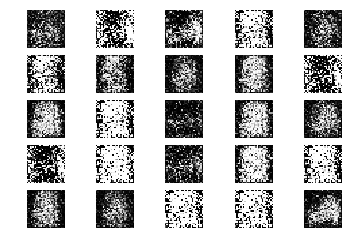

201 [D loss: 0.265206, acc.: 87.50%] [G loss: 3.503477]
202 [D loss: 0.340121, acc.: 87.50%] [G loss: 3.852644]
203 [D loss: 0.383081, acc.: 81.25%] [G loss: 4.179162]
204 [D loss: 0.195882, acc.: 95.31%] [G loss: 3.312064]
205 [D loss: 0.301793, acc.: 87.50%] [G loss: 4.212060]
206 [D loss: 0.274364, acc.: 89.06%] [G loss: 3.786737]
207 [D loss: 0.500102, acc.: 71.88%] [G loss: 3.479881]
208 [D loss: 0.420449, acc.: 76.56%] [G loss: 3.596500]
209 [D loss: 0.424768, acc.: 79.69%] [G loss: 3.606669]
210 [D loss: 0.208993, acc.: 89.06%] [G loss: 4.131785]
211 [D loss: 0.572687, acc.: 71.88%] [G loss: 4.036965]
212 [D loss: 0.303769, acc.: 92.19%] [G loss: 4.060290]
213 [D loss: 0.298304, acc.: 90.62%] [G loss: 3.303384]
214 [D loss: 0.293909, acc.: 82.81%] [G loss: 3.670490]
215 [D loss: 0.281168, acc.: 92.19%] [G loss: 2.956773]
216 [D loss: 0.431469, acc.: 78.12%] [G loss: 2.996643]
217 [D loss: 0.169715, acc.: 93.75%] [G loss: 3.790349]
218 [D loss: 0.323989, acc.: 81.25%] [G loss: 3.

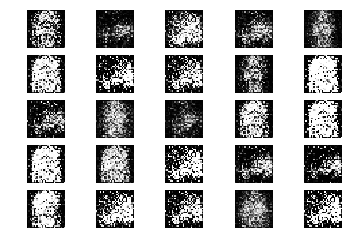

401 [D loss: 0.451593, acc.: 78.12%] [G loss: 2.955876]
402 [D loss: 0.471894, acc.: 73.44%] [G loss: 2.786341]
403 [D loss: 0.655633, acc.: 78.12%] [G loss: 2.741194]
404 [D loss: 0.648938, acc.: 65.62%] [G loss: 2.443578]
405 [D loss: 0.414899, acc.: 82.81%] [G loss: 2.906367]
406 [D loss: 0.570085, acc.: 64.06%] [G loss: 3.021853]
407 [D loss: 0.401765, acc.: 85.94%] [G loss: 2.474415]
408 [D loss: 0.570144, acc.: 70.31%] [G loss: 2.516560]
409 [D loss: 0.403338, acc.: 78.12%] [G loss: 3.340191]
410 [D loss: 0.501583, acc.: 75.00%] [G loss: 2.353327]
411 [D loss: 0.529484, acc.: 70.31%] [G loss: 2.972847]
412 [D loss: 0.402121, acc.: 82.81%] [G loss: 3.332718]
413 [D loss: 0.648600, acc.: 65.62%] [G loss: 2.168564]
414 [D loss: 0.384768, acc.: 89.06%] [G loss: 2.894305]
415 [D loss: 0.705946, acc.: 62.50%] [G loss: 2.294783]
416 [D loss: 0.644984, acc.: 65.62%] [G loss: 2.508171]
417 [D loss: 0.603909, acc.: 73.44%] [G loss: 2.316034]
418 [D loss: 0.881880, acc.: 50.00%] [G loss: 3.

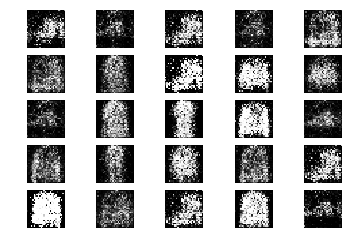

601 [D loss: 0.679545, acc.: 60.94%] [G loss: 1.233063]
602 [D loss: 0.610335, acc.: 68.75%] [G loss: 1.244138]
603 [D loss: 0.634086, acc.: 73.44%] [G loss: 1.395545]
604 [D loss: 0.677709, acc.: 67.19%] [G loss: 1.413025]
605 [D loss: 0.658427, acc.: 70.31%] [G loss: 1.175429]
606 [D loss: 0.652404, acc.: 60.94%] [G loss: 1.401860]
607 [D loss: 0.675576, acc.: 62.50%] [G loss: 1.085596]
608 [D loss: 0.658831, acc.: 64.06%] [G loss: 1.119069]
609 [D loss: 0.682943, acc.: 64.06%] [G loss: 1.231792]
610 [D loss: 0.656174, acc.: 70.31%] [G loss: 1.188853]
611 [D loss: 0.641807, acc.: 68.75%] [G loss: 1.266891]
612 [D loss: 0.637678, acc.: 67.19%] [G loss: 1.420591]
613 [D loss: 0.659908, acc.: 56.25%] [G loss: 1.352949]
614 [D loss: 0.740798, acc.: 51.56%] [G loss: 1.171558]
615 [D loss: 0.601974, acc.: 68.75%] [G loss: 1.108956]
616 [D loss: 0.588707, acc.: 73.44%] [G loss: 1.395618]
617 [D loss: 0.658065, acc.: 76.56%] [G loss: 1.448409]
618 [D loss: 0.705174, acc.: 54.69%] [G loss: 1.

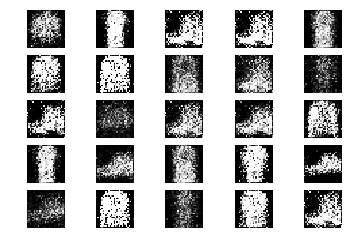

801 [D loss: 0.674569, acc.: 57.81%] [G loss: 1.046442]
802 [D loss: 0.623244, acc.: 62.50%] [G loss: 0.986234]
803 [D loss: 0.513459, acc.: 79.69%] [G loss: 1.103715]
804 [D loss: 0.581752, acc.: 67.19%] [G loss: 1.125405]
805 [D loss: 0.580760, acc.: 70.31%] [G loss: 1.168258]
806 [D loss: 0.646353, acc.: 64.06%] [G loss: 1.091813]
807 [D loss: 0.615265, acc.: 70.31%] [G loss: 1.015486]
808 [D loss: 0.554302, acc.: 75.00%] [G loss: 1.166252]
809 [D loss: 0.635915, acc.: 59.38%] [G loss: 1.083590]
810 [D loss: 0.599305, acc.: 71.88%] [G loss: 1.100203]
811 [D loss: 0.691816, acc.: 59.38%] [G loss: 1.043829]
812 [D loss: 0.743099, acc.: 48.44%] [G loss: 0.942037]
813 [D loss: 0.651986, acc.: 59.38%] [G loss: 1.002446]
814 [D loss: 0.614314, acc.: 67.19%] [G loss: 1.139904]
815 [D loss: 0.618644, acc.: 64.06%] [G loss: 1.122228]
816 [D loss: 0.720962, acc.: 51.56%] [G loss: 1.128054]
817 [D loss: 0.715899, acc.: 59.38%] [G loss: 0.981615]
818 [D loss: 0.629839, acc.: 64.06%] [G loss: 0.

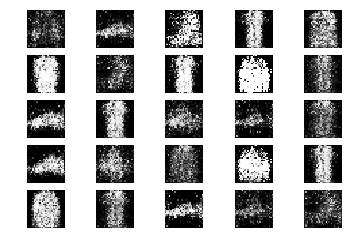

1001 [D loss: 0.604106, acc.: 64.06%] [G loss: 1.039312]
1002 [D loss: 0.649870, acc.: 62.50%] [G loss: 1.001586]
1003 [D loss: 0.646311, acc.: 51.56%] [G loss: 1.002155]
1004 [D loss: 0.653994, acc.: 57.81%] [G loss: 0.977106]
1005 [D loss: 0.611581, acc.: 64.06%] [G loss: 0.970124]
1006 [D loss: 0.689303, acc.: 53.12%] [G loss: 1.046436]
1007 [D loss: 0.647822, acc.: 70.31%] [G loss: 1.107324]
1008 [D loss: 0.658204, acc.: 54.69%] [G loss: 0.972232]
1009 [D loss: 0.623335, acc.: 68.75%] [G loss: 1.043200]
1010 [D loss: 0.602626, acc.: 71.88%] [G loss: 1.009992]
1011 [D loss: 0.625880, acc.: 59.38%] [G loss: 1.062515]
1012 [D loss: 0.709378, acc.: 42.19%] [G loss: 0.951956]
1013 [D loss: 0.642420, acc.: 56.25%] [G loss: 0.946238]
1014 [D loss: 0.590816, acc.: 68.75%] [G loss: 0.988886]
1015 [D loss: 0.571237, acc.: 70.31%] [G loss: 0.957839]
1016 [D loss: 0.748505, acc.: 46.88%] [G loss: 0.926224]
1017 [D loss: 0.708363, acc.: 48.44%] [G loss: 1.062264]
1018 [D loss: 0.600931, acc.: 7

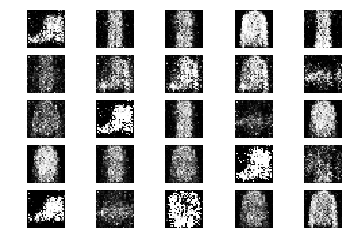

1201 [D loss: 0.718157, acc.: 50.00%] [G loss: 0.879385]
1202 [D loss: 0.674608, acc.: 56.25%] [G loss: 0.877409]
1203 [D loss: 0.611965, acc.: 67.19%] [G loss: 0.979513]
1204 [D loss: 0.653298, acc.: 62.50%] [G loss: 0.864580]
1205 [D loss: 0.694460, acc.: 59.38%] [G loss: 0.860298]
1206 [D loss: 0.652843, acc.: 50.00%] [G loss: 0.841034]
1207 [D loss: 0.639943, acc.: 65.62%] [G loss: 0.857213]
1208 [D loss: 0.654080, acc.: 59.38%] [G loss: 0.825246]
1209 [D loss: 0.684135, acc.: 57.81%] [G loss: 0.784121]
1210 [D loss: 0.625093, acc.: 59.38%] [G loss: 0.966712]
1211 [D loss: 0.690213, acc.: 65.62%] [G loss: 0.934322]
1212 [D loss: 0.638336, acc.: 56.25%] [G loss: 0.911910]
1213 [D loss: 0.670210, acc.: 60.94%] [G loss: 0.925856]
1214 [D loss: 0.703703, acc.: 57.81%] [G loss: 0.832738]
1215 [D loss: 0.633743, acc.: 64.06%] [G loss: 0.934734]
1216 [D loss: 0.662315, acc.: 51.56%] [G loss: 0.996668]
1217 [D loss: 0.666558, acc.: 53.12%] [G loss: 0.940214]
1218 [D loss: 0.628106, acc.: 6

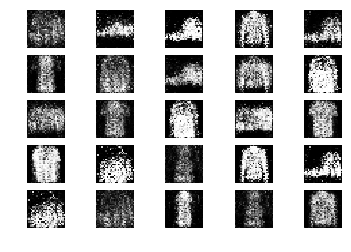

1401 [D loss: 0.629425, acc.: 68.75%] [G loss: 0.889033]
1402 [D loss: 0.743056, acc.: 50.00%] [G loss: 0.893380]
1403 [D loss: 0.749915, acc.: 43.75%] [G loss: 0.859294]
1404 [D loss: 0.700848, acc.: 54.69%] [G loss: 0.932787]
1405 [D loss: 0.719294, acc.: 53.12%] [G loss: 0.865966]
1406 [D loss: 0.716664, acc.: 43.75%] [G loss: 0.893785]
1407 [D loss: 0.682887, acc.: 60.94%] [G loss: 0.882128]
1408 [D loss: 0.726957, acc.: 42.19%] [G loss: 0.898870]
1409 [D loss: 0.728300, acc.: 50.00%] [G loss: 0.967462]
1410 [D loss: 0.743144, acc.: 46.88%] [G loss: 0.840281]
1411 [D loss: 0.667273, acc.: 56.25%] [G loss: 0.848567]
1412 [D loss: 0.727843, acc.: 42.19%] [G loss: 0.806204]
1413 [D loss: 0.737662, acc.: 51.56%] [G loss: 0.830614]
1414 [D loss: 0.616121, acc.: 65.62%] [G loss: 0.894837]
1415 [D loss: 0.702797, acc.: 57.81%] [G loss: 0.842679]
1416 [D loss: 0.663194, acc.: 56.25%] [G loss: 0.942852]
1417 [D loss: 0.687716, acc.: 59.38%] [G loss: 0.867887]
1418 [D loss: 0.737310, acc.: 4

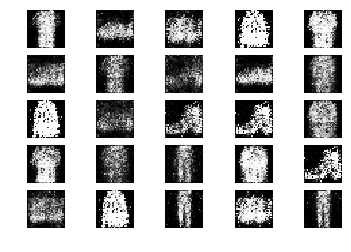

1601 [D loss: 0.714575, acc.: 53.12%] [G loss: 0.810171]
1602 [D loss: 0.735989, acc.: 45.31%] [G loss: 0.797731]
1603 [D loss: 0.750704, acc.: 40.62%] [G loss: 0.752174]
1604 [D loss: 0.719497, acc.: 48.44%] [G loss: 0.795781]
1605 [D loss: 0.771775, acc.: 42.19%] [G loss: 0.886913]
1606 [D loss: 0.684335, acc.: 62.50%] [G loss: 0.887229]
1607 [D loss: 0.702367, acc.: 54.69%] [G loss: 0.903959]
1608 [D loss: 0.735924, acc.: 56.25%] [G loss: 0.860786]
1609 [D loss: 0.755619, acc.: 48.44%] [G loss: 0.784418]
1610 [D loss: 0.646732, acc.: 64.06%] [G loss: 0.815275]
1611 [D loss: 0.723350, acc.: 51.56%] [G loss: 0.831318]
1612 [D loss: 0.718227, acc.: 40.62%] [G loss: 0.760638]
1613 [D loss: 0.729904, acc.: 45.31%] [G loss: 0.854468]
1614 [D loss: 0.733936, acc.: 39.06%] [G loss: 0.815032]
1615 [D loss: 0.686498, acc.: 48.44%] [G loss: 0.779931]
1616 [D loss: 0.677443, acc.: 59.38%] [G loss: 0.710715]
1617 [D loss: 0.691755, acc.: 57.81%] [G loss: 0.748563]
1618 [D loss: 0.628595, acc.: 6

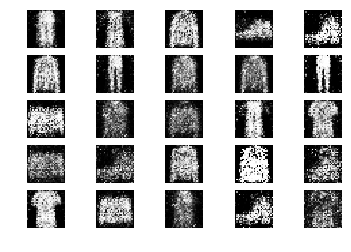

1801 [D loss: 0.699490, acc.: 46.88%] [G loss: 0.779488]
1802 [D loss: 0.691035, acc.: 51.56%] [G loss: 0.772523]
1803 [D loss: 0.699042, acc.: 48.44%] [G loss: 0.778638]
1804 [D loss: 0.657685, acc.: 53.12%] [G loss: 0.826453]
1805 [D loss: 0.648648, acc.: 53.12%] [G loss: 0.804817]
1806 [D loss: 0.680416, acc.: 57.81%] [G loss: 0.833511]
1807 [D loss: 0.681080, acc.: 56.25%] [G loss: 0.820981]
1808 [D loss: 0.631724, acc.: 65.62%] [G loss: 0.833719]
1809 [D loss: 0.680967, acc.: 53.12%] [G loss: 0.916990]
1810 [D loss: 0.646039, acc.: 59.38%] [G loss: 0.822582]
1811 [D loss: 0.719851, acc.: 50.00%] [G loss: 0.777038]
1812 [D loss: 0.697600, acc.: 54.69%] [G loss: 0.822059]
1813 [D loss: 0.676590, acc.: 53.12%] [G loss: 0.822172]
1814 [D loss: 0.643218, acc.: 60.94%] [G loss: 0.839130]
1815 [D loss: 0.623341, acc.: 59.38%] [G loss: 0.785012]
1816 [D loss: 0.713547, acc.: 53.12%] [G loss: 0.777069]
1817 [D loss: 0.715072, acc.: 46.88%] [G loss: 0.787589]
1818 [D loss: 0.660885, acc.: 5

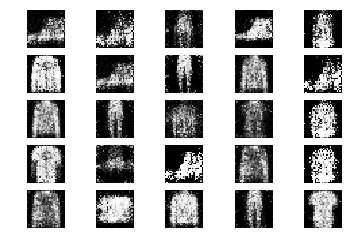

2001 [D loss: 0.709797, acc.: 50.00%] [G loss: 0.849907]
2002 [D loss: 0.670760, acc.: 62.50%] [G loss: 0.847239]
2003 [D loss: 0.721297, acc.: 50.00%] [G loss: 0.798473]
2004 [D loss: 0.646056, acc.: 57.81%] [G loss: 0.861130]
2005 [D loss: 0.694179, acc.: 53.12%] [G loss: 0.781225]
2006 [D loss: 0.659434, acc.: 54.69%] [G loss: 0.822703]
2007 [D loss: 0.692528, acc.: 45.31%] [G loss: 0.797089]
2008 [D loss: 0.677535, acc.: 50.00%] [G loss: 0.788315]
2009 [D loss: 0.692961, acc.: 43.75%] [G loss: 0.774214]
2010 [D loss: 0.667196, acc.: 60.94%] [G loss: 0.739966]
2011 [D loss: 0.699588, acc.: 53.12%] [G loss: 0.801646]
2012 [D loss: 0.689133, acc.: 64.06%] [G loss: 0.750890]
2013 [D loss: 0.647808, acc.: 59.38%] [G loss: 0.775697]
2014 [D loss: 0.654058, acc.: 53.12%] [G loss: 0.794981]
2015 [D loss: 0.762858, acc.: 46.88%] [G loss: 0.801985]
2016 [D loss: 0.648923, acc.: 62.50%] [G loss: 0.816819]
2017 [D loss: 0.691851, acc.: 50.00%] [G loss: 0.781728]
2018 [D loss: 0.711659, acc.: 5

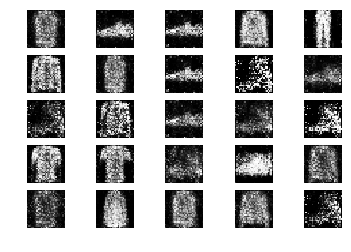

2201 [D loss: 0.686875, acc.: 56.25%] [G loss: 0.787621]
2202 [D loss: 0.647148, acc.: 54.69%] [G loss: 0.779449]
2203 [D loss: 0.672866, acc.: 56.25%] [G loss: 0.752448]
2204 [D loss: 0.736927, acc.: 42.19%] [G loss: 0.844912]
2205 [D loss: 0.709528, acc.: 57.81%] [G loss: 0.787734]
2206 [D loss: 0.652192, acc.: 57.81%] [G loss: 0.777627]
2207 [D loss: 0.648303, acc.: 54.69%] [G loss: 0.784274]
2208 [D loss: 0.664644, acc.: 60.94%] [G loss: 0.778493]
2209 [D loss: 0.684290, acc.: 56.25%] [G loss: 0.809894]
2210 [D loss: 0.646643, acc.: 62.50%] [G loss: 0.784909]
2211 [D loss: 0.660995, acc.: 65.62%] [G loss: 0.884344]
2212 [D loss: 0.686438, acc.: 57.81%] [G loss: 0.785662]
2213 [D loss: 0.688431, acc.: 53.12%] [G loss: 0.806962]
2214 [D loss: 0.661540, acc.: 57.81%] [G loss: 0.791769]
2215 [D loss: 0.683956, acc.: 48.44%] [G loss: 0.820141]
2216 [D loss: 0.660996, acc.: 56.25%] [G loss: 0.797809]
2217 [D loss: 0.692571, acc.: 53.12%] [G loss: 0.755779]
2218 [D loss: 0.678642, acc.: 5

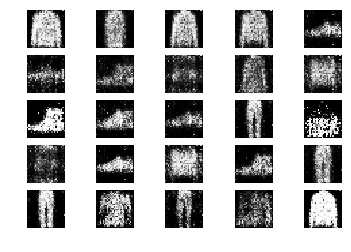

2401 [D loss: 0.719103, acc.: 43.75%] [G loss: 0.808331]
2402 [D loss: 0.697634, acc.: 50.00%] [G loss: 0.840979]
2403 [D loss: 0.660829, acc.: 56.25%] [G loss: 0.759219]
2404 [D loss: 0.771298, acc.: 43.75%] [G loss: 0.808377]
2405 [D loss: 0.665722, acc.: 56.25%] [G loss: 0.801397]
2406 [D loss: 0.719622, acc.: 46.88%] [G loss: 0.798578]
2407 [D loss: 0.677355, acc.: 59.38%] [G loss: 0.783768]
2408 [D loss: 0.689689, acc.: 46.88%] [G loss: 0.785559]
2409 [D loss: 0.625764, acc.: 67.19%] [G loss: 0.810977]
2410 [D loss: 0.695409, acc.: 53.12%] [G loss: 0.825891]
2411 [D loss: 0.617301, acc.: 67.19%] [G loss: 0.800709]
2412 [D loss: 0.698475, acc.: 46.88%] [G loss: 0.791584]
2413 [D loss: 0.702838, acc.: 51.56%] [G loss: 0.834069]
2414 [D loss: 0.683101, acc.: 54.69%] [G loss: 0.721186]
2415 [D loss: 0.735831, acc.: 39.06%] [G loss: 0.808332]
2416 [D loss: 0.696311, acc.: 53.12%] [G loss: 0.814805]
2417 [D loss: 0.670490, acc.: 60.94%] [G loss: 0.782348]
2418 [D loss: 0.650925, acc.: 5

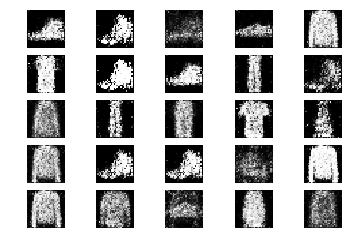

2601 [D loss: 0.712713, acc.: 56.25%] [G loss: 0.803859]
2602 [D loss: 0.672202, acc.: 60.94%] [G loss: 0.832795]
2603 [D loss: 0.700725, acc.: 51.56%] [G loss: 0.751872]
2604 [D loss: 0.694459, acc.: 56.25%] [G loss: 0.798443]
2605 [D loss: 0.691281, acc.: 59.38%] [G loss: 0.866093]
2606 [D loss: 0.674146, acc.: 46.88%] [G loss: 0.904590]
2607 [D loss: 0.682523, acc.: 57.81%] [G loss: 0.848997]
2608 [D loss: 0.662346, acc.: 56.25%] [G loss: 0.857404]
2609 [D loss: 0.653431, acc.: 59.38%] [G loss: 0.812090]
2610 [D loss: 0.625810, acc.: 64.06%] [G loss: 0.818442]
2611 [D loss: 0.678673, acc.: 51.56%] [G loss: 0.855027]
2612 [D loss: 0.710421, acc.: 50.00%] [G loss: 0.833639]
2613 [D loss: 0.662767, acc.: 67.19%] [G loss: 0.825379]
2614 [D loss: 0.660285, acc.: 60.94%] [G loss: 0.780763]
2615 [D loss: 0.654489, acc.: 57.81%] [G loss: 0.699283]
2616 [D loss: 0.678472, acc.: 60.94%] [G loss: 0.786829]
2617 [D loss: 0.667103, acc.: 56.25%] [G loss: 0.819349]
2618 [D loss: 0.653194, acc.: 6

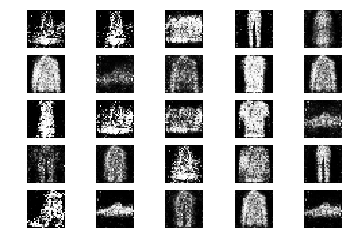

2801 [D loss: 0.653362, acc.: 62.50%] [G loss: 0.760945]
2802 [D loss: 0.639426, acc.: 65.62%] [G loss: 0.776905]
2803 [D loss: 0.646694, acc.: 59.38%] [G loss: 0.767633]
2804 [D loss: 0.667631, acc.: 60.94%] [G loss: 0.734256]
2805 [D loss: 0.694108, acc.: 54.69%] [G loss: 0.841773]
2806 [D loss: 0.649934, acc.: 62.50%] [G loss: 0.777001]
2807 [D loss: 0.658038, acc.: 64.06%] [G loss: 0.758961]
2808 [D loss: 0.655031, acc.: 64.06%] [G loss: 0.766017]
2809 [D loss: 0.680880, acc.: 51.56%] [G loss: 0.792169]
2810 [D loss: 0.641698, acc.: 60.94%] [G loss: 0.854445]
2811 [D loss: 0.669108, acc.: 53.12%] [G loss: 0.854960]
2812 [D loss: 0.646755, acc.: 56.25%] [G loss: 0.851596]
2813 [D loss: 0.657593, acc.: 64.06%] [G loss: 0.827740]
2814 [D loss: 0.689810, acc.: 48.44%] [G loss: 0.818191]
2815 [D loss: 0.645197, acc.: 62.50%] [G loss: 0.869624]
2816 [D loss: 0.641318, acc.: 60.94%] [G loss: 0.805435]
2817 [D loss: 0.666379, acc.: 62.50%] [G loss: 0.797483]
2818 [D loss: 0.652120, acc.: 6

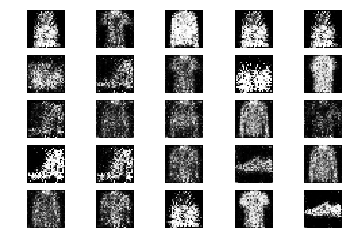

3001 [D loss: 0.701828, acc.: 51.56%] [G loss: 0.799938]
3002 [D loss: 0.743637, acc.: 51.56%] [G loss: 0.851609]
3003 [D loss: 0.622782, acc.: 71.88%] [G loss: 0.788746]
3004 [D loss: 0.652983, acc.: 65.62%] [G loss: 0.837799]
3005 [D loss: 0.679287, acc.: 59.38%] [G loss: 0.839459]
3006 [D loss: 0.680225, acc.: 62.50%] [G loss: 0.809462]
3007 [D loss: 0.672482, acc.: 57.81%] [G loss: 0.841413]
3008 [D loss: 0.656348, acc.: 68.75%] [G loss: 0.849360]
3009 [D loss: 0.684139, acc.: 54.69%] [G loss: 0.821002]
3010 [D loss: 0.652924, acc.: 65.62%] [G loss: 0.779846]
3011 [D loss: 0.687769, acc.: 59.38%] [G loss: 0.778954]
3012 [D loss: 0.640874, acc.: 56.25%] [G loss: 0.845256]
3013 [D loss: 0.638482, acc.: 68.75%] [G loss: 0.776635]
3014 [D loss: 0.639706, acc.: 65.62%] [G loss: 0.808376]
3015 [D loss: 0.712021, acc.: 54.69%] [G loss: 0.776321]
3016 [D loss: 0.681158, acc.: 53.12%] [G loss: 0.801092]
3017 [D loss: 0.684549, acc.: 54.69%] [G loss: 0.811140]
3018 [D loss: 0.702386, acc.: 5

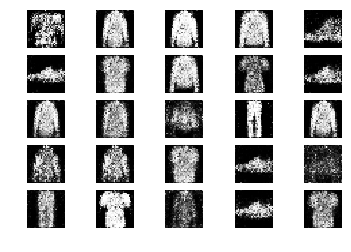

3201 [D loss: 0.662041, acc.: 60.94%] [G loss: 0.832307]
3202 [D loss: 0.697740, acc.: 60.94%] [G loss: 0.818121]
3203 [D loss: 0.764884, acc.: 39.06%] [G loss: 0.843901]
3204 [D loss: 0.691898, acc.: 54.69%] [G loss: 0.818354]
3205 [D loss: 0.690603, acc.: 59.38%] [G loss: 0.815746]
3206 [D loss: 0.696337, acc.: 46.88%] [G loss: 0.880813]
3207 [D loss: 0.627944, acc.: 64.06%] [G loss: 0.858545]
3208 [D loss: 0.639814, acc.: 64.06%] [G loss: 0.844095]
3209 [D loss: 0.681475, acc.: 54.69%] [G loss: 0.761097]
3210 [D loss: 0.661124, acc.: 57.81%] [G loss: 0.844457]
3211 [D loss: 0.661712, acc.: 65.62%] [G loss: 0.795001]
3212 [D loss: 0.640709, acc.: 68.75%] [G loss: 0.813903]
3213 [D loss: 0.662230, acc.: 59.38%] [G loss: 0.764800]
3214 [D loss: 0.708861, acc.: 59.38%] [G loss: 0.730857]
3215 [D loss: 0.639664, acc.: 59.38%] [G loss: 0.816189]
3216 [D loss: 0.733187, acc.: 51.56%] [G loss: 0.843130]
3217 [D loss: 0.632173, acc.: 68.75%] [G loss: 0.779983]
3218 [D loss: 0.673258, acc.: 5

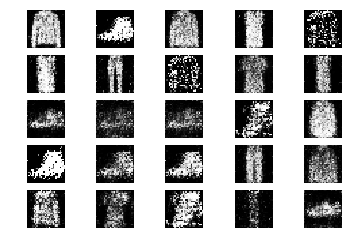

3401 [D loss: 0.619253, acc.: 64.06%] [G loss: 0.902029]
3402 [D loss: 0.676050, acc.: 48.44%] [G loss: 0.889812]
3403 [D loss: 0.682071, acc.: 51.56%] [G loss: 0.887107]
3404 [D loss: 0.672628, acc.: 51.56%] [G loss: 0.894708]
3405 [D loss: 0.645428, acc.: 62.50%] [G loss: 0.870946]
3406 [D loss: 0.725301, acc.: 54.69%] [G loss: 0.782835]
3407 [D loss: 0.700912, acc.: 50.00%] [G loss: 0.739142]
3408 [D loss: 0.659993, acc.: 57.81%] [G loss: 0.806259]
3409 [D loss: 0.668527, acc.: 56.25%] [G loss: 0.826183]
3410 [D loss: 0.591070, acc.: 70.31%] [G loss: 0.811498]
3411 [D loss: 0.642540, acc.: 60.94%] [G loss: 0.822482]
3412 [D loss: 0.635992, acc.: 64.06%] [G loss: 0.860675]
3413 [D loss: 0.633443, acc.: 59.38%] [G loss: 0.882115]
3414 [D loss: 0.692444, acc.: 56.25%] [G loss: 0.884264]
3415 [D loss: 0.702617, acc.: 51.56%] [G loss: 0.846676]
3416 [D loss: 0.642558, acc.: 73.44%] [G loss: 0.850249]
3417 [D loss: 0.648448, acc.: 60.94%] [G loss: 0.744053]
3418 [D loss: 0.797194, acc.: 4

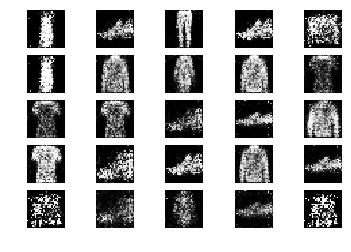

3601 [D loss: 0.708571, acc.: 48.44%] [G loss: 0.851264]
3602 [D loss: 0.633710, acc.: 65.62%] [G loss: 0.905589]
3603 [D loss: 0.711285, acc.: 45.31%] [G loss: 0.824812]
3604 [D loss: 0.636679, acc.: 62.50%] [G loss: 0.864812]
3605 [D loss: 0.609587, acc.: 59.38%] [G loss: 0.850673]
3606 [D loss: 0.653450, acc.: 67.19%] [G loss: 0.836588]
3607 [D loss: 0.626388, acc.: 67.19%] [G loss: 0.888557]
3608 [D loss: 0.727975, acc.: 51.56%] [G loss: 0.890103]
3609 [D loss: 0.645377, acc.: 56.25%] [G loss: 0.921439]
3610 [D loss: 0.660527, acc.: 57.81%] [G loss: 0.846615]
3611 [D loss: 0.653981, acc.: 56.25%] [G loss: 0.824141]
3612 [D loss: 0.660981, acc.: 53.12%] [G loss: 0.775251]
3613 [D loss: 0.687693, acc.: 54.69%] [G loss: 0.759668]
3614 [D loss: 0.655110, acc.: 59.38%] [G loss: 0.777124]
3615 [D loss: 0.686319, acc.: 50.00%] [G loss: 0.842875]
3616 [D loss: 0.697220, acc.: 50.00%] [G loss: 0.853076]
3617 [D loss: 0.693590, acc.: 54.69%] [G loss: 0.873317]
3618 [D loss: 0.698938, acc.: 5

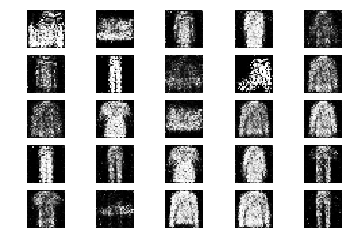

3801 [D loss: 0.651348, acc.: 57.81%] [G loss: 0.857258]
3802 [D loss: 0.699986, acc.: 50.00%] [G loss: 0.841096]
3803 [D loss: 0.617101, acc.: 64.06%] [G loss: 0.807141]
3804 [D loss: 0.642114, acc.: 57.81%] [G loss: 0.889663]
3805 [D loss: 0.649232, acc.: 56.25%] [G loss: 0.803621]
3806 [D loss: 0.655498, acc.: 59.38%] [G loss: 0.867871]
3807 [D loss: 0.651085, acc.: 64.06%] [G loss: 0.763787]
3808 [D loss: 0.672951, acc.: 62.50%] [G loss: 0.816373]
3809 [D loss: 0.642400, acc.: 65.62%] [G loss: 0.847584]
3810 [D loss: 0.662958, acc.: 62.50%] [G loss: 0.867941]
3811 [D loss: 0.678789, acc.: 57.81%] [G loss: 0.924772]
3812 [D loss: 0.686244, acc.: 53.12%] [G loss: 0.889361]
3813 [D loss: 0.616851, acc.: 64.06%] [G loss: 0.887580]
3814 [D loss: 0.674211, acc.: 56.25%] [G loss: 0.868903]
3815 [D loss: 0.688299, acc.: 53.12%] [G loss: 0.868905]
3816 [D loss: 0.705815, acc.: 56.25%] [G loss: 0.847359]
3817 [D loss: 0.654292, acc.: 60.94%] [G loss: 0.858797]
3818 [D loss: 0.695166, acc.: 5

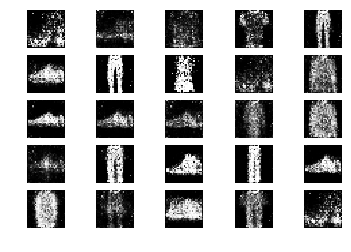

4001 [D loss: 0.717849, acc.: 43.75%] [G loss: 0.851492]
4002 [D loss: 0.713087, acc.: 54.69%] [G loss: 0.831408]
4003 [D loss: 0.695915, acc.: 54.69%] [G loss: 0.822990]
4004 [D loss: 0.694709, acc.: 46.88%] [G loss: 0.904552]
4005 [D loss: 0.681002, acc.: 57.81%] [G loss: 0.841723]
4006 [D loss: 0.678343, acc.: 54.69%] [G loss: 0.831508]
4007 [D loss: 0.657335, acc.: 57.81%] [G loss: 0.758104]
4008 [D loss: 0.654757, acc.: 60.94%] [G loss: 0.792828]
4009 [D loss: 0.695479, acc.: 51.56%] [G loss: 0.782341]
4010 [D loss: 0.680910, acc.: 56.25%] [G loss: 0.820159]
4011 [D loss: 0.680279, acc.: 57.81%] [G loss: 0.813107]
4012 [D loss: 0.676179, acc.: 60.94%] [G loss: 0.850573]
4013 [D loss: 0.618386, acc.: 59.38%] [G loss: 0.835470]
4014 [D loss: 0.674631, acc.: 64.06%] [G loss: 0.908762]
4015 [D loss: 0.654565, acc.: 54.69%] [G loss: 0.940656]
4016 [D loss: 0.700823, acc.: 53.12%] [G loss: 0.876622]
4017 [D loss: 0.635313, acc.: 59.38%] [G loss: 0.867923]
4018 [D loss: 0.708594, acc.: 4

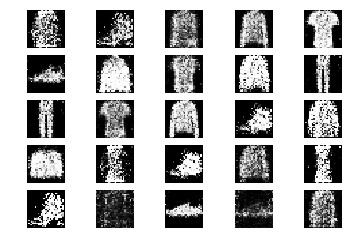

4201 [D loss: 0.682490, acc.: 59.38%] [G loss: 0.969358]
4202 [D loss: 0.648579, acc.: 54.69%] [G loss: 0.860582]
4203 [D loss: 0.668249, acc.: 60.94%] [G loss: 0.855245]
4204 [D loss: 0.684570, acc.: 60.94%] [G loss: 0.970563]
4205 [D loss: 0.614885, acc.: 62.50%] [G loss: 0.899661]
4206 [D loss: 0.687886, acc.: 51.56%] [G loss: 0.909027]
4207 [D loss: 0.739338, acc.: 51.56%] [G loss: 0.853124]
4208 [D loss: 0.671433, acc.: 54.69%] [G loss: 0.847743]
4209 [D loss: 0.700346, acc.: 53.12%] [G loss: 0.876593]
4210 [D loss: 0.657349, acc.: 60.94%] [G loss: 0.856762]
4211 [D loss: 0.600911, acc.: 70.31%] [G loss: 0.942402]
4212 [D loss: 0.686831, acc.: 57.81%] [G loss: 0.851810]
4213 [D loss: 0.680616, acc.: 59.38%] [G loss: 0.853373]
4214 [D loss: 0.672983, acc.: 57.81%] [G loss: 0.825229]
4215 [D loss: 0.682782, acc.: 56.25%] [G loss: 0.854587]
4216 [D loss: 0.685937, acc.: 48.44%] [G loss: 0.810636]
4217 [D loss: 0.670647, acc.: 57.81%] [G loss: 0.795776]
4218 [D loss: 0.714888, acc.: 4

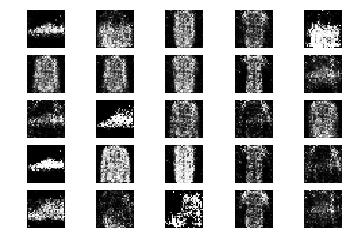

4401 [D loss: 0.669535, acc.: 56.25%] [G loss: 0.898378]
4402 [D loss: 0.651555, acc.: 60.94%] [G loss: 0.901603]
4403 [D loss: 0.681618, acc.: 48.44%] [G loss: 0.890702]
4404 [D loss: 0.677760, acc.: 56.25%] [G loss: 0.884802]
4405 [D loss: 0.682648, acc.: 56.25%] [G loss: 0.859678]
4406 [D loss: 0.670735, acc.: 59.38%] [G loss: 0.904429]
4407 [D loss: 0.612795, acc.: 67.19%] [G loss: 0.892640]
4408 [D loss: 0.679319, acc.: 48.44%] [G loss: 0.877681]
4409 [D loss: 0.610077, acc.: 65.62%] [G loss: 0.949449]
4410 [D loss: 0.641886, acc.: 57.81%] [G loss: 0.893293]
4411 [D loss: 0.681096, acc.: 50.00%] [G loss: 0.858512]
4412 [D loss: 0.677026, acc.: 53.12%] [G loss: 0.866394]
4413 [D loss: 0.713064, acc.: 46.88%] [G loss: 0.934813]
4414 [D loss: 0.700754, acc.: 54.69%] [G loss: 0.976702]
4415 [D loss: 0.644009, acc.: 62.50%] [G loss: 0.926790]
4416 [D loss: 0.730836, acc.: 45.31%] [G loss: 0.881114]
4417 [D loss: 0.644171, acc.: 62.50%] [G loss: 0.840617]
4418 [D loss: 0.722613, acc.: 5

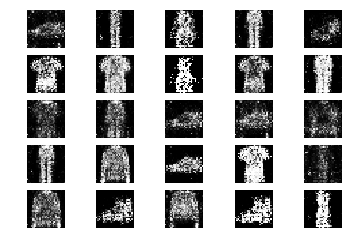

4601 [D loss: 0.711958, acc.: 48.44%] [G loss: 0.835611]
4602 [D loss: 0.610050, acc.: 62.50%] [G loss: 0.944517]
4603 [D loss: 0.653010, acc.: 59.38%] [G loss: 0.979419]
4604 [D loss: 0.693450, acc.: 53.12%] [G loss: 1.027649]
4605 [D loss: 0.672975, acc.: 51.56%] [G loss: 0.951342]
4606 [D loss: 0.755507, acc.: 46.88%] [G loss: 0.957643]
4607 [D loss: 0.658882, acc.: 64.06%] [G loss: 0.958413]
4608 [D loss: 0.651949, acc.: 56.25%] [G loss: 0.945181]
4609 [D loss: 0.665481, acc.: 53.12%] [G loss: 0.897042]
4610 [D loss: 0.702247, acc.: 56.25%] [G loss: 0.854819]
4611 [D loss: 0.606994, acc.: 68.75%] [G loss: 0.859977]
4612 [D loss: 0.667789, acc.: 56.25%] [G loss: 0.893756]
4613 [D loss: 0.586805, acc.: 65.62%] [G loss: 0.939892]
4614 [D loss: 0.640542, acc.: 56.25%] [G loss: 0.894894]
4615 [D loss: 0.720959, acc.: 45.31%] [G loss: 0.923578]
4616 [D loss: 0.642240, acc.: 54.69%] [G loss: 0.943937]
4617 [D loss: 0.623827, acc.: 68.75%] [G loss: 0.974519]
4618 [D loss: 0.641263, acc.: 6

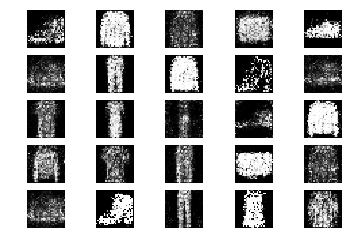

4801 [D loss: 0.713540, acc.: 46.88%] [G loss: 0.832324]
4802 [D loss: 0.659900, acc.: 62.50%] [G loss: 0.794067]
4803 [D loss: 0.639286, acc.: 62.50%] [G loss: 0.862999]
4804 [D loss: 0.688128, acc.: 56.25%] [G loss: 0.807394]
4805 [D loss: 0.656682, acc.: 59.38%] [G loss: 0.842233]
4806 [D loss: 0.654272, acc.: 64.06%] [G loss: 0.846320]
4807 [D loss: 0.688295, acc.: 50.00%] [G loss: 0.801403]
4808 [D loss: 0.684592, acc.: 54.69%] [G loss: 0.804905]
4809 [D loss: 0.664115, acc.: 59.38%] [G loss: 0.832944]
4810 [D loss: 0.664600, acc.: 67.19%] [G loss: 0.861085]
4811 [D loss: 0.593586, acc.: 79.69%] [G loss: 0.976289]
4812 [D loss: 0.630244, acc.: 65.62%] [G loss: 0.967297]
4813 [D loss: 0.695762, acc.: 54.69%] [G loss: 0.928474]
4814 [D loss: 0.648008, acc.: 67.19%] [G loss: 0.881280]
4815 [D loss: 0.655261, acc.: 64.06%] [G loss: 0.927234]
4816 [D loss: 0.661253, acc.: 62.50%] [G loss: 0.844830]
4817 [D loss: 0.629588, acc.: 67.19%] [G loss: 0.870581]
4818 [D loss: 0.611632, acc.: 6

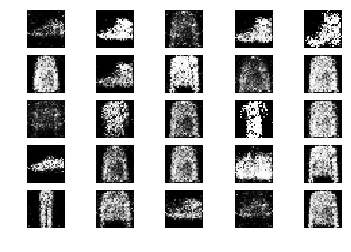

5001 [D loss: 0.685857, acc.: 57.81%] [G loss: 0.896726]
5002 [D loss: 0.708270, acc.: 57.81%] [G loss: 0.911339]
5003 [D loss: 0.658170, acc.: 60.94%] [G loss: 0.932447]
5004 [D loss: 0.662428, acc.: 64.06%] [G loss: 0.942246]
5005 [D loss: 0.686103, acc.: 60.94%] [G loss: 0.951914]
5006 [D loss: 0.630220, acc.: 60.94%] [G loss: 0.894260]
5007 [D loss: 0.677540, acc.: 57.81%] [G loss: 0.798483]
5008 [D loss: 0.645859, acc.: 57.81%] [G loss: 0.871074]
5009 [D loss: 0.627388, acc.: 64.06%] [G loss: 0.889668]
5010 [D loss: 0.714316, acc.: 45.31%] [G loss: 0.873458]
5011 [D loss: 0.671404, acc.: 62.50%] [G loss: 0.929357]
5012 [D loss: 0.623197, acc.: 64.06%] [G loss: 0.853885]
5013 [D loss: 0.647867, acc.: 60.94%] [G loss: 0.888355]
5014 [D loss: 0.614453, acc.: 70.31%] [G loss: 0.861907]
5015 [D loss: 0.718643, acc.: 51.56%] [G loss: 0.864775]
5016 [D loss: 0.629026, acc.: 67.19%] [G loss: 0.949415]
5017 [D loss: 0.756961, acc.: 50.00%] [G loss: 0.994051]
5018 [D loss: 0.699148, acc.: 5

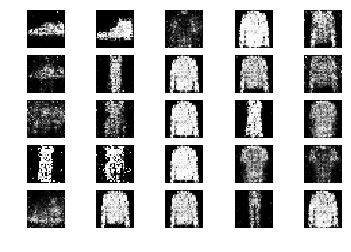

5201 [D loss: 0.699609, acc.: 54.69%] [G loss: 0.810899]
5202 [D loss: 0.701700, acc.: 51.56%] [G loss: 0.823009]
5203 [D loss: 0.726449, acc.: 54.69%] [G loss: 0.841969]
5204 [D loss: 0.630643, acc.: 60.94%] [G loss: 0.865694]
5205 [D loss: 0.628478, acc.: 65.62%] [G loss: 0.854842]
5206 [D loss: 0.725678, acc.: 48.44%] [G loss: 0.886352]
5207 [D loss: 0.658918, acc.: 59.38%] [G loss: 0.806383]
5208 [D loss: 0.686629, acc.: 54.69%] [G loss: 0.845446]
5209 [D loss: 0.680035, acc.: 53.12%] [G loss: 0.903256]
5210 [D loss: 0.665825, acc.: 54.69%] [G loss: 0.844999]
5211 [D loss: 0.677483, acc.: 62.50%] [G loss: 0.886276]
5212 [D loss: 0.632294, acc.: 62.50%] [G loss: 0.872000]
5213 [D loss: 0.652300, acc.: 62.50%] [G loss: 0.898806]
5214 [D loss: 0.680638, acc.: 54.69%] [G loss: 0.962689]
5215 [D loss: 0.695502, acc.: 42.19%] [G loss: 0.887707]
5216 [D loss: 0.684403, acc.: 56.25%] [G loss: 0.895080]
5217 [D loss: 0.667883, acc.: 57.81%] [G loss: 0.899752]
5218 [D loss: 0.613598, acc.: 6

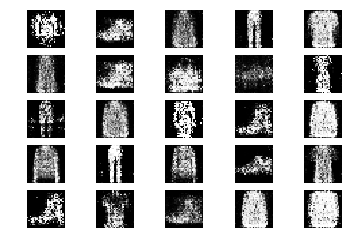

5401 [D loss: 0.774528, acc.: 45.31%] [G loss: 0.830717]
5402 [D loss: 0.639027, acc.: 64.06%] [G loss: 0.853343]
5403 [D loss: 0.663116, acc.: 67.19%] [G loss: 0.854879]
5404 [D loss: 0.603750, acc.: 65.62%] [G loss: 0.900310]
5405 [D loss: 0.635068, acc.: 67.19%] [G loss: 0.955216]
5406 [D loss: 0.684675, acc.: 60.94%] [G loss: 0.965316]
5407 [D loss: 0.706713, acc.: 50.00%] [G loss: 0.902489]
5408 [D loss: 0.634931, acc.: 64.06%] [G loss: 0.821826]
5409 [D loss: 0.663491, acc.: 64.06%] [G loss: 0.834698]
5410 [D loss: 0.685359, acc.: 53.12%] [G loss: 0.857370]
5411 [D loss: 0.622282, acc.: 68.75%] [G loss: 0.876245]
5412 [D loss: 0.661964, acc.: 62.50%] [G loss: 0.805051]
5413 [D loss: 0.651800, acc.: 60.94%] [G loss: 0.902154]
5414 [D loss: 0.619528, acc.: 60.94%] [G loss: 0.914690]
5415 [D loss: 0.660187, acc.: 64.06%] [G loss: 0.890835]
5416 [D loss: 0.682685, acc.: 54.69%] [G loss: 0.830114]
5417 [D loss: 0.627205, acc.: 70.31%] [G loss: 0.927995]
5418 [D loss: 0.596838, acc.: 7

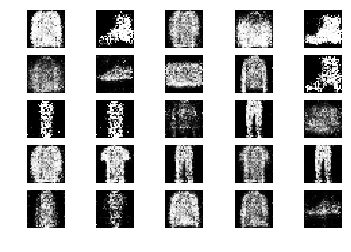

5601 [D loss: 0.691787, acc.: 54.69%] [G loss: 0.895938]
5602 [D loss: 0.646326, acc.: 65.62%] [G loss: 0.848559]
5603 [D loss: 0.647490, acc.: 64.06%] [G loss: 0.810703]
5604 [D loss: 0.664863, acc.: 64.06%] [G loss: 0.818194]
5605 [D loss: 0.572953, acc.: 78.12%] [G loss: 0.820419]
5606 [D loss: 0.638255, acc.: 64.06%] [G loss: 0.931918]
5607 [D loss: 0.693447, acc.: 64.06%] [G loss: 0.819771]
5608 [D loss: 0.672233, acc.: 54.69%] [G loss: 0.936980]
5609 [D loss: 0.632950, acc.: 65.62%] [G loss: 0.855343]
5610 [D loss: 0.646352, acc.: 59.38%] [G loss: 0.850034]
5611 [D loss: 0.684272, acc.: 46.88%] [G loss: 0.781201]
5612 [D loss: 0.671000, acc.: 59.38%] [G loss: 0.914472]
5613 [D loss: 0.662039, acc.: 56.25%] [G loss: 0.873319]
5614 [D loss: 0.664111, acc.: 62.50%] [G loss: 0.926537]
5615 [D loss: 0.639094, acc.: 60.94%] [G loss: 0.909114]
5616 [D loss: 0.693454, acc.: 51.56%] [G loss: 0.896763]
5617 [D loss: 0.710285, acc.: 48.44%] [G loss: 0.850734]
5618 [D loss: 0.687881, acc.: 5

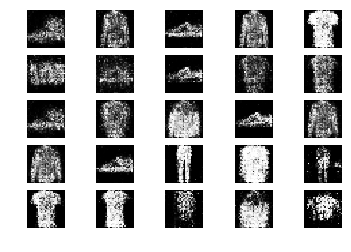

5801 [D loss: 0.696290, acc.: 48.44%] [G loss: 0.868652]
5802 [D loss: 0.687791, acc.: 51.56%] [G loss: 0.847435]
5803 [D loss: 0.649300, acc.: 62.50%] [G loss: 0.836561]
5804 [D loss: 0.607481, acc.: 73.44%] [G loss: 0.807270]
5805 [D loss: 0.664550, acc.: 48.44%] [G loss: 0.823026]
5806 [D loss: 0.689972, acc.: 57.81%] [G loss: 0.855894]
5807 [D loss: 0.616820, acc.: 73.44%] [G loss: 1.008863]
5808 [D loss: 0.637733, acc.: 65.62%] [G loss: 0.875928]
5809 [D loss: 0.714805, acc.: 54.69%] [G loss: 0.819735]
5810 [D loss: 0.694390, acc.: 54.69%] [G loss: 0.856853]
5811 [D loss: 0.704723, acc.: 53.12%] [G loss: 0.824827]
5812 [D loss: 0.619042, acc.: 67.19%] [G loss: 0.868867]
5813 [D loss: 0.626347, acc.: 59.38%] [G loss: 0.853570]
5814 [D loss: 0.627115, acc.: 67.19%] [G loss: 0.859615]
5815 [D loss: 0.673122, acc.: 57.81%] [G loss: 0.940359]
5816 [D loss: 0.723684, acc.: 46.88%] [G loss: 0.836483]
5817 [D loss: 0.651882, acc.: 57.81%] [G loss: 0.893522]
5818 [D loss: 0.703178, acc.: 4

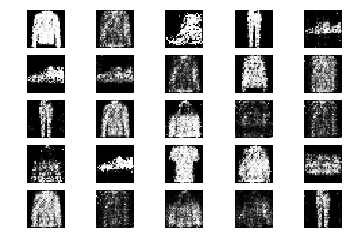

6001 [D loss: 0.624006, acc.: 67.19%] [G loss: 0.906425]
6002 [D loss: 0.645012, acc.: 57.81%] [G loss: 0.918459]
6003 [D loss: 0.642555, acc.: 59.38%] [G loss: 0.899039]
6004 [D loss: 0.730766, acc.: 46.88%] [G loss: 0.912387]
6005 [D loss: 0.662676, acc.: 62.50%] [G loss: 0.864723]
6006 [D loss: 0.671773, acc.: 56.25%] [G loss: 0.817019]
6007 [D loss: 0.737919, acc.: 50.00%] [G loss: 0.925362]
6008 [D loss: 0.623963, acc.: 71.88%] [G loss: 0.835895]
6009 [D loss: 0.712024, acc.: 56.25%] [G loss: 0.791459]
6010 [D loss: 0.668442, acc.: 54.69%] [G loss: 0.873044]
6011 [D loss: 0.684403, acc.: 51.56%] [G loss: 0.929166]
6012 [D loss: 0.665390, acc.: 56.25%] [G loss: 0.857466]
6013 [D loss: 0.648772, acc.: 60.94%] [G loss: 0.877949]
6014 [D loss: 0.623782, acc.: 68.75%] [G loss: 0.841971]
6015 [D loss: 0.587078, acc.: 68.75%] [G loss: 0.841470]
6016 [D loss: 0.679630, acc.: 48.44%] [G loss: 0.868708]
6017 [D loss: 0.618667, acc.: 62.50%] [G loss: 0.822298]
6018 [D loss: 0.594394, acc.: 7

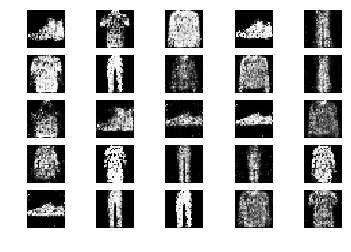

6201 [D loss: 0.680336, acc.: 56.25%] [G loss: 0.798761]
6202 [D loss: 0.643521, acc.: 62.50%] [G loss: 0.808306]
6203 [D loss: 0.655718, acc.: 50.00%] [G loss: 0.842043]
6204 [D loss: 0.674901, acc.: 60.94%] [G loss: 0.820718]
6205 [D loss: 0.696125, acc.: 51.56%] [G loss: 0.793713]
6206 [D loss: 0.667832, acc.: 50.00%] [G loss: 0.837746]
6207 [D loss: 0.654291, acc.: 57.81%] [G loss: 0.879050]
6208 [D loss: 0.687355, acc.: 54.69%] [G loss: 0.825549]
6209 [D loss: 0.725261, acc.: 48.44%] [G loss: 0.815848]
6210 [D loss: 0.607110, acc.: 62.50%] [G loss: 0.839468]
6211 [D loss: 0.665958, acc.: 57.81%] [G loss: 0.846686]
6212 [D loss: 0.630451, acc.: 65.62%] [G loss: 0.826479]
6213 [D loss: 0.640488, acc.: 65.62%] [G loss: 0.862994]
6214 [D loss: 0.703657, acc.: 51.56%] [G loss: 0.867781]
6215 [D loss: 0.628764, acc.: 57.81%] [G loss: 0.916404]
6216 [D loss: 0.658239, acc.: 56.25%] [G loss: 0.946455]
6217 [D loss: 0.685680, acc.: 59.38%] [G loss: 0.855503]
6218 [D loss: 0.649652, acc.: 5

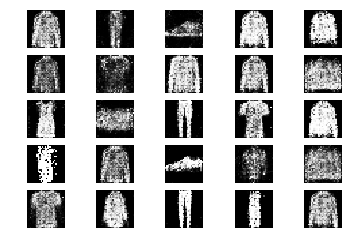

6401 [D loss: 0.667429, acc.: 59.38%] [G loss: 0.859953]
6402 [D loss: 0.658154, acc.: 60.94%] [G loss: 0.887564]
6403 [D loss: 0.660276, acc.: 54.69%] [G loss: 0.906958]
6404 [D loss: 0.661898, acc.: 60.94%] [G loss: 0.865483]
6405 [D loss: 0.692431, acc.: 54.69%] [G loss: 0.865219]
6406 [D loss: 0.607926, acc.: 70.31%] [G loss: 0.960337]
6407 [D loss: 0.718348, acc.: 45.31%] [G loss: 0.825557]
6408 [D loss: 0.667118, acc.: 53.12%] [G loss: 0.873662]
6409 [D loss: 0.631399, acc.: 62.50%] [G loss: 0.892369]
6410 [D loss: 0.643684, acc.: 56.25%] [G loss: 0.891409]
6411 [D loss: 0.613364, acc.: 64.06%] [G loss: 0.861952]
6412 [D loss: 0.706500, acc.: 50.00%] [G loss: 0.912451]
6413 [D loss: 0.613727, acc.: 65.62%] [G loss: 0.975471]
6414 [D loss: 0.653250, acc.: 59.38%] [G loss: 0.925625]
6415 [D loss: 0.685607, acc.: 60.94%] [G loss: 0.880997]
6416 [D loss: 0.618811, acc.: 68.75%] [G loss: 0.881425]
6417 [D loss: 0.630293, acc.: 60.94%] [G loss: 0.861991]
6418 [D loss: 0.634355, acc.: 6

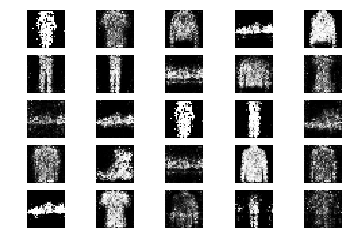

6601 [D loss: 0.724009, acc.: 53.12%] [G loss: 0.882454]
6602 [D loss: 0.657547, acc.: 57.81%] [G loss: 0.835935]
6603 [D loss: 0.735382, acc.: 46.88%] [G loss: 0.869825]
6604 [D loss: 0.680160, acc.: 62.50%] [G loss: 0.829482]
6605 [D loss: 0.692495, acc.: 54.69%] [G loss: 0.873397]
6606 [D loss: 0.620876, acc.: 64.06%] [G loss: 0.873073]
6607 [D loss: 0.635700, acc.: 65.62%] [G loss: 0.876180]
6608 [D loss: 0.689531, acc.: 54.69%] [G loss: 0.873201]
6609 [D loss: 0.668503, acc.: 53.12%] [G loss: 0.872535]
6610 [D loss: 0.668871, acc.: 53.12%] [G loss: 0.978529]
6611 [D loss: 0.664277, acc.: 59.38%] [G loss: 0.928199]
6612 [D loss: 0.655257, acc.: 59.38%] [G loss: 0.940981]
6613 [D loss: 0.689889, acc.: 54.69%] [G loss: 0.947757]
6614 [D loss: 0.697465, acc.: 46.88%] [G loss: 0.887738]
6615 [D loss: 0.619157, acc.: 65.62%] [G loss: 0.883171]
6616 [D loss: 0.667226, acc.: 57.81%] [G loss: 0.938612]
6617 [D loss: 0.630550, acc.: 65.62%] [G loss: 0.880199]
6618 [D loss: 0.654004, acc.: 6

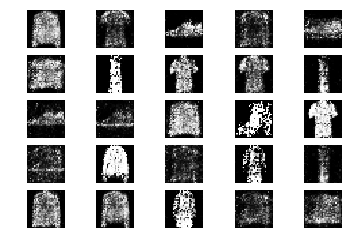

6801 [D loss: 0.640221, acc.: 68.75%] [G loss: 0.908343]
6802 [D loss: 0.676466, acc.: 50.00%] [G loss: 0.936815]
6803 [D loss: 0.682464, acc.: 54.69%] [G loss: 0.965551]
6804 [D loss: 0.628603, acc.: 60.94%] [G loss: 0.910555]
6805 [D loss: 0.637355, acc.: 59.38%] [G loss: 0.912354]
6806 [D loss: 0.637018, acc.: 67.19%] [G loss: 0.810692]
6807 [D loss: 0.621225, acc.: 67.19%] [G loss: 0.954670]
6808 [D loss: 0.617921, acc.: 67.19%] [G loss: 0.894551]
6809 [D loss: 0.683019, acc.: 51.56%] [G loss: 0.853835]
6810 [D loss: 0.622737, acc.: 64.06%] [G loss: 0.871419]
6811 [D loss: 0.650747, acc.: 56.25%] [G loss: 0.780030]
6812 [D loss: 0.643596, acc.: 64.06%] [G loss: 0.820256]
6813 [D loss: 0.644488, acc.: 60.94%] [G loss: 0.902897]
6814 [D loss: 0.614974, acc.: 59.38%] [G loss: 0.938701]
6815 [D loss: 0.659773, acc.: 65.62%] [G loss: 0.936054]
6816 [D loss: 0.685273, acc.: 50.00%] [G loss: 0.924268]
6817 [D loss: 0.614764, acc.: 76.56%] [G loss: 0.932001]
6818 [D loss: 0.638194, acc.: 6

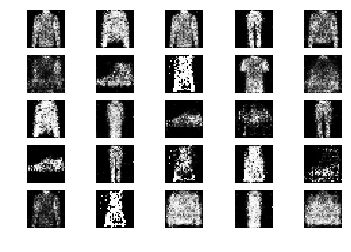

7001 [D loss: 0.744036, acc.: 50.00%] [G loss: 0.837200]
7002 [D loss: 0.706496, acc.: 50.00%] [G loss: 0.889060]
7003 [D loss: 0.654864, acc.: 64.06%] [G loss: 0.847482]
7004 [D loss: 0.682802, acc.: 53.12%] [G loss: 0.828776]
7005 [D loss: 0.620354, acc.: 54.69%] [G loss: 0.876675]
7006 [D loss: 0.697645, acc.: 50.00%] [G loss: 0.922102]
7007 [D loss: 0.659496, acc.: 59.38%] [G loss: 0.881618]
7008 [D loss: 0.691343, acc.: 51.56%] [G loss: 0.895911]
7009 [D loss: 0.645949, acc.: 62.50%] [G loss: 0.864580]
7010 [D loss: 0.719168, acc.: 46.88%] [G loss: 0.821413]
7011 [D loss: 0.684319, acc.: 57.81%] [G loss: 0.890036]
7012 [D loss: 0.700953, acc.: 57.81%] [G loss: 0.844515]
7013 [D loss: 0.641809, acc.: 59.38%] [G loss: 0.912768]
7014 [D loss: 0.649882, acc.: 65.62%] [G loss: 0.924998]
7015 [D loss: 0.651357, acc.: 64.06%] [G loss: 0.826026]
7016 [D loss: 0.686691, acc.: 57.81%] [G loss: 0.909572]
7017 [D loss: 0.627838, acc.: 68.75%] [G loss: 0.937358]
7018 [D loss: 0.700411, acc.: 5

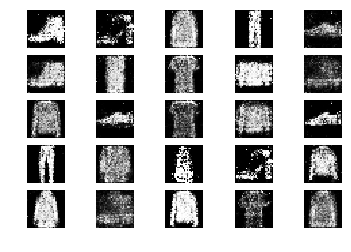

7201 [D loss: 0.685075, acc.: 54.69%] [G loss: 0.891874]
7202 [D loss: 0.641039, acc.: 62.50%] [G loss: 0.853379]
7203 [D loss: 0.615265, acc.: 67.19%] [G loss: 0.853112]
7204 [D loss: 0.657004, acc.: 64.06%] [G loss: 0.869337]
7205 [D loss: 0.629363, acc.: 65.62%] [G loss: 0.822880]
7206 [D loss: 0.624308, acc.: 60.94%] [G loss: 0.787085]
7207 [D loss: 0.639209, acc.: 60.94%] [G loss: 0.818635]
7208 [D loss: 0.647651, acc.: 54.69%] [G loss: 0.948406]
7209 [D loss: 0.641798, acc.: 59.38%] [G loss: 0.924896]
7210 [D loss: 0.628328, acc.: 70.31%] [G loss: 0.884083]
7211 [D loss: 0.633020, acc.: 67.19%] [G loss: 0.876584]
7212 [D loss: 0.678914, acc.: 60.94%] [G loss: 0.886078]
7213 [D loss: 0.710892, acc.: 48.44%] [G loss: 0.937462]
7214 [D loss: 0.677632, acc.: 59.38%] [G loss: 0.909803]
7215 [D loss: 0.688472, acc.: 56.25%] [G loss: 0.847992]
7216 [D loss: 0.659903, acc.: 57.81%] [G loss: 0.941582]
7217 [D loss: 0.640708, acc.: 56.25%] [G loss: 0.937207]
7218 [D loss: 0.663447, acc.: 5

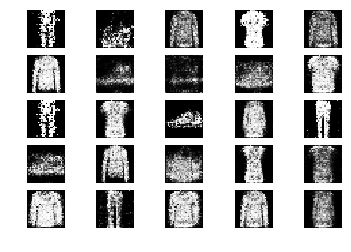

7401 [D loss: 0.608886, acc.: 67.19%] [G loss: 0.955143]
7402 [D loss: 0.622835, acc.: 59.38%] [G loss: 1.026538]
7403 [D loss: 0.691230, acc.: 60.94%] [G loss: 0.928576]
7404 [D loss: 0.706455, acc.: 59.38%] [G loss: 0.914017]
7405 [D loss: 0.742545, acc.: 53.12%] [G loss: 0.779852]
7406 [D loss: 0.649879, acc.: 65.62%] [G loss: 0.939784]
7407 [D loss: 0.645157, acc.: 57.81%] [G loss: 0.934442]
7408 [D loss: 0.702146, acc.: 59.38%] [G loss: 0.980148]
7409 [D loss: 0.685947, acc.: 59.38%] [G loss: 0.964193]
7410 [D loss: 0.686696, acc.: 51.56%] [G loss: 0.977765]
7411 [D loss: 0.690493, acc.: 60.94%] [G loss: 0.965721]
7412 [D loss: 0.644692, acc.: 60.94%] [G loss: 0.893814]
7413 [D loss: 0.684424, acc.: 57.81%] [G loss: 0.839717]
7414 [D loss: 0.629343, acc.: 64.06%] [G loss: 0.895242]
7415 [D loss: 0.644288, acc.: 60.94%] [G loss: 0.928718]
7416 [D loss: 0.592845, acc.: 60.94%] [G loss: 0.928512]
7417 [D loss: 0.772901, acc.: 43.75%] [G loss: 0.894864]
7418 [D loss: 0.709022, acc.: 5

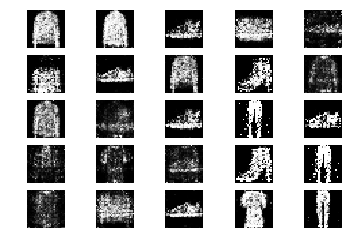

7601 [D loss: 0.662507, acc.: 62.50%] [G loss: 0.980739]
7602 [D loss: 0.694723, acc.: 50.00%] [G loss: 0.869613]
7603 [D loss: 0.642819, acc.: 62.50%] [G loss: 0.890803]
7604 [D loss: 0.627146, acc.: 65.62%] [G loss: 0.922379]
7605 [D loss: 0.641860, acc.: 64.06%] [G loss: 0.956100]
7606 [D loss: 0.614096, acc.: 65.62%] [G loss: 1.021847]
7607 [D loss: 0.647834, acc.: 57.81%] [G loss: 0.998442]
7608 [D loss: 0.691885, acc.: 48.44%] [G loss: 0.982139]
7609 [D loss: 0.653006, acc.: 62.50%] [G loss: 0.849562]
7610 [D loss: 0.659783, acc.: 65.62%] [G loss: 0.886596]
7611 [D loss: 0.662164, acc.: 53.12%] [G loss: 0.878413]
7612 [D loss: 0.668400, acc.: 54.69%] [G loss: 0.936691]
7613 [D loss: 0.681398, acc.: 48.44%] [G loss: 0.923769]
7614 [D loss: 0.637973, acc.: 62.50%] [G loss: 0.943761]
7615 [D loss: 0.677567, acc.: 53.12%] [G loss: 0.927708]
7616 [D loss: 0.635883, acc.: 65.62%] [G loss: 0.914588]
7617 [D loss: 0.637426, acc.: 60.94%] [G loss: 0.995686]
7618 [D loss: 0.671110, acc.: 5

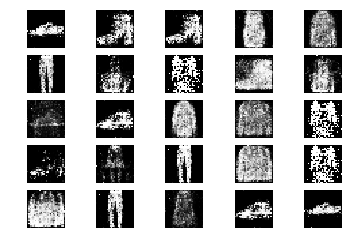

7801 [D loss: 0.683175, acc.: 57.81%] [G loss: 0.953492]
7802 [D loss: 0.632335, acc.: 68.75%] [G loss: 0.847846]
7803 [D loss: 0.719384, acc.: 50.00%] [G loss: 0.942183]
7804 [D loss: 0.657863, acc.: 51.56%] [G loss: 0.862586]
7805 [D loss: 0.645132, acc.: 65.62%] [G loss: 0.801264]
7806 [D loss: 0.641618, acc.: 65.62%] [G loss: 0.934268]
7807 [D loss: 0.655689, acc.: 64.06%] [G loss: 0.935737]
7808 [D loss: 0.699055, acc.: 53.12%] [G loss: 0.801896]
7809 [D loss: 0.717770, acc.: 45.31%] [G loss: 0.809890]
7810 [D loss: 0.675493, acc.: 62.50%] [G loss: 0.911340]
7811 [D loss: 0.666491, acc.: 54.69%] [G loss: 0.956097]
7812 [D loss: 0.662511, acc.: 56.25%] [G loss: 0.830615]
7813 [D loss: 0.654323, acc.: 60.94%] [G loss: 0.907353]
7814 [D loss: 0.627850, acc.: 60.94%] [G loss: 0.883451]
7815 [D loss: 0.677712, acc.: 57.81%] [G loss: 0.945797]
7816 [D loss: 0.579625, acc.: 76.56%] [G loss: 0.911030]
7817 [D loss: 0.698313, acc.: 46.88%] [G loss: 0.983728]
7818 [D loss: 0.617223, acc.: 6

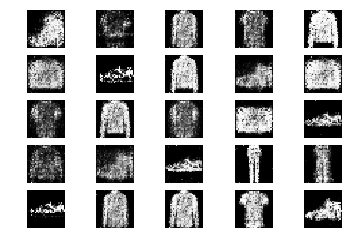

8001 [D loss: 0.631936, acc.: 62.50%] [G loss: 0.926893]
8002 [D loss: 0.676336, acc.: 59.38%] [G loss: 0.853072]
8003 [D loss: 0.622790, acc.: 64.06%] [G loss: 0.916593]
8004 [D loss: 0.672625, acc.: 59.38%] [G loss: 0.910689]
8005 [D loss: 0.651354, acc.: 59.38%] [G loss: 0.819661]
8006 [D loss: 0.622125, acc.: 67.19%] [G loss: 0.918490]
8007 [D loss: 0.678110, acc.: 57.81%] [G loss: 0.909068]
8008 [D loss: 0.677601, acc.: 53.12%] [G loss: 0.865086]
8009 [D loss: 0.683466, acc.: 53.12%] [G loss: 0.893665]
8010 [D loss: 0.720830, acc.: 59.38%] [G loss: 0.874041]
8011 [D loss: 0.662762, acc.: 56.25%] [G loss: 0.846832]
8012 [D loss: 0.651569, acc.: 62.50%] [G loss: 0.889296]
8013 [D loss: 0.687377, acc.: 46.88%] [G loss: 0.887788]
8014 [D loss: 0.653480, acc.: 65.62%] [G loss: 0.838919]
8015 [D loss: 0.661721, acc.: 53.12%] [G loss: 0.957572]
8016 [D loss: 0.696140, acc.: 56.25%] [G loss: 0.989629]
8017 [D loss: 0.683493, acc.: 51.56%] [G loss: 0.928127]
8018 [D loss: 0.666272, acc.: 5

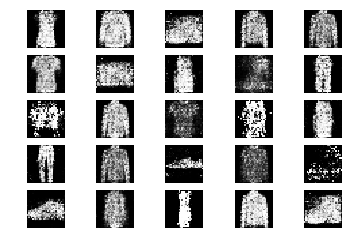

8201 [D loss: 0.623735, acc.: 60.94%] [G loss: 0.896322]
8202 [D loss: 0.630893, acc.: 64.06%] [G loss: 0.877275]
8203 [D loss: 0.632891, acc.: 64.06%] [G loss: 0.869519]
8204 [D loss: 0.651943, acc.: 50.00%] [G loss: 0.850557]
8205 [D loss: 0.668602, acc.: 56.25%] [G loss: 0.874093]
8206 [D loss: 0.656544, acc.: 57.81%] [G loss: 0.850381]
8207 [D loss: 0.649982, acc.: 57.81%] [G loss: 0.840367]
8208 [D loss: 0.656164, acc.: 70.31%] [G loss: 0.853623]
8209 [D loss: 0.634039, acc.: 65.62%] [G loss: 0.847178]
8210 [D loss: 0.649952, acc.: 62.50%] [G loss: 0.874601]
8211 [D loss: 0.724977, acc.: 46.88%] [G loss: 0.805373]
8212 [D loss: 0.635916, acc.: 60.94%] [G loss: 0.819920]
8213 [D loss: 0.679204, acc.: 51.56%] [G loss: 0.885449]
8214 [D loss: 0.633095, acc.: 65.62%] [G loss: 0.894953]
8215 [D loss: 0.683421, acc.: 59.38%] [G loss: 0.998496]
8216 [D loss: 0.835744, acc.: 39.06%] [G loss: 0.886077]
8217 [D loss: 0.623452, acc.: 73.44%] [G loss: 0.858764]
8218 [D loss: 0.659587, acc.: 6

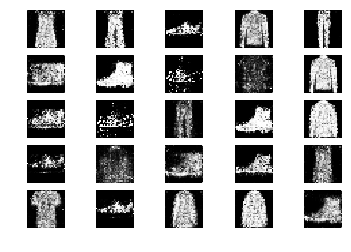

8401 [D loss: 0.649046, acc.: 67.19%] [G loss: 0.919055]
8402 [D loss: 0.686719, acc.: 54.69%] [G loss: 0.911796]
8403 [D loss: 0.638839, acc.: 60.94%] [G loss: 0.913742]
8404 [D loss: 0.593106, acc.: 65.62%] [G loss: 0.902033]
8405 [D loss: 0.695547, acc.: 60.94%] [G loss: 0.833318]
8406 [D loss: 0.670094, acc.: 59.38%] [G loss: 0.820589]
8407 [D loss: 0.661825, acc.: 65.62%] [G loss: 0.851242]
8408 [D loss: 0.623071, acc.: 59.38%] [G loss: 0.909460]
8409 [D loss: 0.635562, acc.: 59.38%] [G loss: 0.856017]
8410 [D loss: 0.661213, acc.: 57.81%] [G loss: 0.823604]
8411 [D loss: 0.657617, acc.: 59.38%] [G loss: 0.898867]
8412 [D loss: 0.702634, acc.: 56.25%] [G loss: 0.765922]
8413 [D loss: 0.697762, acc.: 59.38%] [G loss: 0.838546]
8414 [D loss: 0.646201, acc.: 57.81%] [G loss: 0.777650]
8415 [D loss: 0.675077, acc.: 56.25%] [G loss: 0.851817]
8416 [D loss: 0.617291, acc.: 68.75%] [G loss: 0.915599]
8417 [D loss: 0.600430, acc.: 64.06%] [G loss: 0.930040]
8418 [D loss: 0.678326, acc.: 5

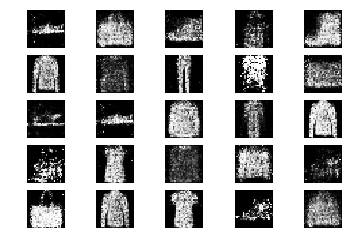

8601 [D loss: 0.720247, acc.: 50.00%] [G loss: 0.828754]
8602 [D loss: 0.678352, acc.: 54.69%] [G loss: 0.848722]
8603 [D loss: 0.682925, acc.: 48.44%] [G loss: 0.878035]
8604 [D loss: 0.654577, acc.: 56.25%] [G loss: 0.816685]
8605 [D loss: 0.661451, acc.: 53.12%] [G loss: 0.967036]
8606 [D loss: 0.681477, acc.: 60.94%] [G loss: 0.904841]
8607 [D loss: 0.690248, acc.: 53.12%] [G loss: 0.917792]
8608 [D loss: 0.648215, acc.: 64.06%] [G loss: 0.911105]
8609 [D loss: 0.655912, acc.: 64.06%] [G loss: 0.824553]
8610 [D loss: 0.633317, acc.: 64.06%] [G loss: 0.829691]
8611 [D loss: 0.671071, acc.: 57.81%] [G loss: 0.832161]
8612 [D loss: 0.666885, acc.: 56.25%] [G loss: 0.802517]
8613 [D loss: 0.665733, acc.: 59.38%] [G loss: 0.819641]
8614 [D loss: 0.645440, acc.: 57.81%] [G loss: 0.755697]
8615 [D loss: 0.675220, acc.: 56.25%] [G loss: 0.709620]
8616 [D loss: 0.661631, acc.: 64.06%] [G loss: 0.809120]
8617 [D loss: 0.681689, acc.: 57.81%] [G loss: 0.864695]
8618 [D loss: 0.668267, acc.: 5

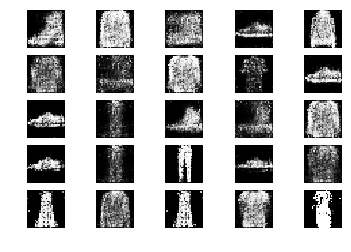

8801 [D loss: 0.678214, acc.: 53.12%] [G loss: 0.890426]
8802 [D loss: 0.674969, acc.: 60.94%] [G loss: 0.850242]
8803 [D loss: 0.654306, acc.: 59.38%] [G loss: 0.902419]
8804 [D loss: 0.654110, acc.: 62.50%] [G loss: 0.926236]
8805 [D loss: 0.671126, acc.: 54.69%] [G loss: 0.879518]
8806 [D loss: 0.666787, acc.: 57.81%] [G loss: 0.907620]
8807 [D loss: 0.729415, acc.: 53.12%] [G loss: 0.916140]
8808 [D loss: 0.639119, acc.: 67.19%] [G loss: 0.888581]
8809 [D loss: 0.667154, acc.: 60.94%] [G loss: 0.959002]
8810 [D loss: 0.688586, acc.: 51.56%] [G loss: 0.901893]
8811 [D loss: 0.675244, acc.: 46.88%] [G loss: 0.867900]
8812 [D loss: 0.754377, acc.: 42.19%] [G loss: 0.807368]
8813 [D loss: 0.638621, acc.: 62.50%] [G loss: 0.839875]
8814 [D loss: 0.739929, acc.: 53.12%] [G loss: 0.883996]
8815 [D loss: 0.711456, acc.: 51.56%] [G loss: 0.852713]
8816 [D loss: 0.684850, acc.: 59.38%] [G loss: 0.801227]
8817 [D loss: 0.676682, acc.: 54.69%] [G loss: 0.765687]
8818 [D loss: 0.697189, acc.: 5

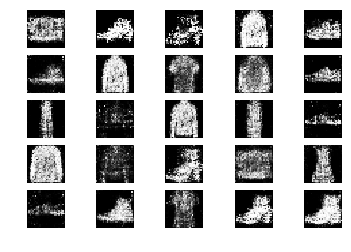

9001 [D loss: 0.619686, acc.: 67.19%] [G loss: 0.916806]
9002 [D loss: 0.687360, acc.: 59.38%] [G loss: 0.793847]
9003 [D loss: 0.704602, acc.: 45.31%] [G loss: 0.759109]
9004 [D loss: 0.663345, acc.: 60.94%] [G loss: 0.884639]
9005 [D loss: 0.639707, acc.: 57.81%] [G loss: 0.865834]
9006 [D loss: 0.663359, acc.: 67.19%] [G loss: 0.894668]
9007 [D loss: 0.698599, acc.: 51.56%] [G loss: 0.963833]
9008 [D loss: 0.667797, acc.: 57.81%] [G loss: 0.884680]
9009 [D loss: 0.663248, acc.: 57.81%] [G loss: 0.920218]
9010 [D loss: 0.636098, acc.: 57.81%] [G loss: 0.928929]
9011 [D loss: 0.653004, acc.: 59.38%] [G loss: 0.868632]
9012 [D loss: 0.653728, acc.: 64.06%] [G loss: 0.809827]
9013 [D loss: 0.622113, acc.: 65.62%] [G loss: 0.912178]
9014 [D loss: 0.693168, acc.: 56.25%] [G loss: 0.951891]
9015 [D loss: 0.651034, acc.: 62.50%] [G loss: 0.928917]
9016 [D loss: 0.640723, acc.: 60.94%] [G loss: 0.969958]
9017 [D loss: 0.674606, acc.: 59.38%] [G loss: 0.927331]
9018 [D loss: 0.606623, acc.: 7

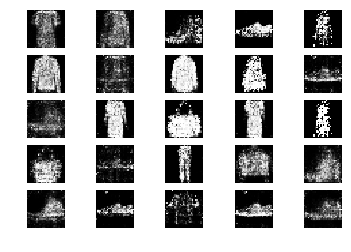

9201 [D loss: 0.677589, acc.: 60.94%] [G loss: 0.874668]
9202 [D loss: 0.629937, acc.: 70.31%] [G loss: 0.872625]
9203 [D loss: 0.682734, acc.: 67.19%] [G loss: 0.810320]
9204 [D loss: 0.669707, acc.: 64.06%] [G loss: 0.803751]
9205 [D loss: 0.674969, acc.: 57.81%] [G loss: 0.835361]
9206 [D loss: 0.697004, acc.: 53.12%] [G loss: 0.917119]
9207 [D loss: 0.621506, acc.: 59.38%] [G loss: 0.824136]
9208 [D loss: 0.689268, acc.: 59.38%] [G loss: 0.757038]
9209 [D loss: 0.698346, acc.: 53.12%] [G loss: 0.799217]
9210 [D loss: 0.732346, acc.: 50.00%] [G loss: 0.837716]
9211 [D loss: 0.671385, acc.: 57.81%] [G loss: 0.843485]
9212 [D loss: 0.714187, acc.: 46.88%] [G loss: 0.787949]
9213 [D loss: 0.648264, acc.: 70.31%] [G loss: 0.856049]
9214 [D loss: 0.688183, acc.: 56.25%] [G loss: 0.820341]
9215 [D loss: 0.722759, acc.: 46.88%] [G loss: 0.823712]
9216 [D loss: 0.677893, acc.: 54.69%] [G loss: 0.814936]
9217 [D loss: 0.648976, acc.: 59.38%] [G loss: 0.865494]
9218 [D loss: 0.691306, acc.: 5

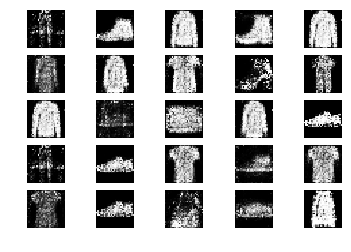

9401 [D loss: 0.695953, acc.: 57.81%] [G loss: 0.876409]
9402 [D loss: 0.675015, acc.: 56.25%] [G loss: 0.876626]
9403 [D loss: 0.681411, acc.: 60.94%] [G loss: 0.828149]
9404 [D loss: 0.646952, acc.: 56.25%] [G loss: 0.840655]
9405 [D loss: 0.685382, acc.: 51.56%] [G loss: 0.814425]
9406 [D loss: 0.698415, acc.: 59.38%] [G loss: 0.878044]
9407 [D loss: 0.753031, acc.: 40.62%] [G loss: 0.771771]
9408 [D loss: 0.709395, acc.: 50.00%] [G loss: 0.764920]
9409 [D loss: 0.713048, acc.: 42.19%] [G loss: 0.762404]
9410 [D loss: 0.659085, acc.: 59.38%] [G loss: 0.840542]
9411 [D loss: 0.658016, acc.: 59.38%] [G loss: 0.865055]
9412 [D loss: 0.727520, acc.: 54.69%] [G loss: 0.798258]
9413 [D loss: 0.661938, acc.: 53.12%] [G loss: 0.829079]
9414 [D loss: 0.675638, acc.: 59.38%] [G loss: 0.814515]
9415 [D loss: 0.679296, acc.: 56.25%] [G loss: 0.842940]
9416 [D loss: 0.671517, acc.: 59.38%] [G loss: 0.902394]
9417 [D loss: 0.661972, acc.: 64.06%] [G loss: 0.891999]
9418 [D loss: 0.682754, acc.: 6

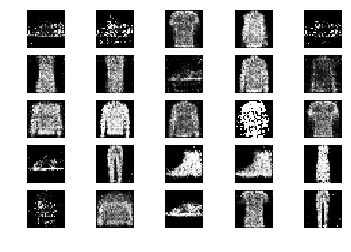

9601 [D loss: 0.682284, acc.: 57.81%] [G loss: 0.889955]
9602 [D loss: 0.674273, acc.: 51.56%] [G loss: 0.902244]
9603 [D loss: 0.612094, acc.: 64.06%] [G loss: 0.877647]
9604 [D loss: 0.692776, acc.: 56.25%] [G loss: 0.807026]
9605 [D loss: 0.710109, acc.: 50.00%] [G loss: 0.780683]
9606 [D loss: 0.636830, acc.: 70.31%] [G loss: 0.828235]
9607 [D loss: 0.696189, acc.: 50.00%] [G loss: 0.848891]
9608 [D loss: 0.672307, acc.: 54.69%] [G loss: 0.854388]
9609 [D loss: 0.680472, acc.: 57.81%] [G loss: 0.843517]
9610 [D loss: 0.655451, acc.: 57.81%] [G loss: 0.869445]
9611 [D loss: 0.647169, acc.: 59.38%] [G loss: 0.852498]
9612 [D loss: 0.647329, acc.: 62.50%] [G loss: 0.865913]
9613 [D loss: 0.738932, acc.: 45.31%] [G loss: 0.840025]
9614 [D loss: 0.650220, acc.: 64.06%] [G loss: 0.799099]
9615 [D loss: 0.650655, acc.: 59.38%] [G loss: 0.845333]
9616 [D loss: 0.710106, acc.: 51.56%] [G loss: 0.885920]
9617 [D loss: 0.658036, acc.: 60.94%] [G loss: 0.896565]
9618 [D loss: 0.657096, acc.: 6

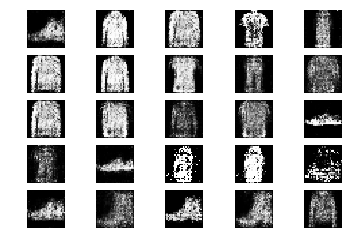

9801 [D loss: 0.639481, acc.: 57.81%] [G loss: 0.879290]
9802 [D loss: 0.652512, acc.: 57.81%] [G loss: 0.913181]
9803 [D loss: 0.614159, acc.: 67.19%] [G loss: 0.921419]
9804 [D loss: 0.711673, acc.: 51.56%] [G loss: 0.881170]
9805 [D loss: 0.680912, acc.: 57.81%] [G loss: 0.862915]
9806 [D loss: 0.693854, acc.: 56.25%] [G loss: 0.819738]
9807 [D loss: 0.613953, acc.: 71.88%] [G loss: 0.851246]
9808 [D loss: 0.635329, acc.: 65.62%] [G loss: 0.848758]
9809 [D loss: 0.662818, acc.: 59.38%] [G loss: 0.875080]
9810 [D loss: 0.658568, acc.: 62.50%] [G loss: 0.827325]
9811 [D loss: 0.641396, acc.: 56.25%] [G loss: 0.907234]
9812 [D loss: 0.717530, acc.: 56.25%] [G loss: 0.806860]
9813 [D loss: 0.612195, acc.: 70.31%] [G loss: 0.881121]
9814 [D loss: 0.652122, acc.: 70.31%] [G loss: 0.868430]
9815 [D loss: 0.652245, acc.: 60.94%] [G loss: 0.886254]
9816 [D loss: 0.656557, acc.: 62.50%] [G loss: 0.854947]
9817 [D loss: 0.646886, acc.: 62.50%] [G loss: 0.804180]
9818 [D loss: 0.650480, acc.: 6

In [5]:
if __name__ == '__main__':
    gan = GAN()
    gan.train(epochs=10000, batch_size=32, sample_interval=200)